# Feature Prototype
First I created a basic minesweeper concept. I added the option to flag potential mine positions in order to allow the information of a previous guess to be saved. This is mainly important for how I have planned my rulebased AI to function. I gave my Minesweeper class potential inputs for initialisation that not only allow for different sizes other than beginner level with different amount of mines, but also to create consistent minesweeper grids with the help of a set seed. This will, in theory, allow me to compare Kane and Able despite the randomness of the mine placements on Minesweeper grids.

In [1]:
#here will be all the modules necessary
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
#class for creating Minesweeper
class Minesweeper:
    def __init__(self, width=8, height=8, mines=10, seed=None):
        #general variables for creating the Minesweeper grid + mines
        self.width = width
        self.height = height
        self.noOfMines = mines
        #variable for placing the mines
        alreadyPlacedMines = 0

        #potentially defining a seed to ensure reproducability
        self.seed = seed
        if seed is not None:
            random.seed(seed)

        #creating three grids
        #This grid is basically the actual grid, with numbers indicating the number of mines around each number tile, while -1 will represent a mine
        self.grid = np.zeros((height, width), dtype=int)
        #this grid is for the current state of the tile, whether it has been uncovered or if it is still unkown
        self.covered = np.ones((height, width), dtype=bool)
        #this grid if for flagging specific tile (whether a flag is placed or not)
        self.flags = np.zeros((height, width), dtype=bool)

        #placing the mines onto the grid
        while alreadyPlacedMines < self.noOfMines:
            #finding a random location for a mine
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            #checking if there is a mine already or not
            if self.grid[y, x] == 0:
                self.grid[y, x] = -1
                alreadyPlacedMines += 1
                #all surrounding tiles get +1 added to their counter unless it is a mine (as it would delete it)
                for i in range(max(0, y-1), min(self.height, y+2)):
                    for j in range(max(0, x-1), min(self.width, x+2)):
                        if self.grid[i, j] != -1:
                            self.grid[i, j] += 1
                            
    #function for flagging a position
    def toggleFlag(self, x, y):
        if self.covered[y, x]:
            self.flags[y, x] = not self.flags[y, x]

    #function for uncovering a tile and revealing whats underneath
    def revealTile(self, x, y):
        #checking if it is already uncovered or flagged, if yes then return prematurely
        if not self.covered[y, x] or self.flags[y, x]:
            return 0
        self.covered[y, x] = False
        #checking if there was a mine
        if self.grid[y, x] == -1:
            return -1
        #if the number tile was a 0, it means that the surrounding tiles are also number tiles and are automatically revealed as well by calling this function recursively
        if self.grid[y, x] == 0:
            for i in range(max(0, y-1), min(self.height, y+2)):
                for j in range(max(0, x-1), min(self.width, x+2)):
                    if self.covered[i, j] and self.flags[i, j] == 0:
                        self.revealTile(j, i)
        return 1

    #function for printing the grid. It simply works by adding the corresponding symbols/numbers to the individual rows before then printing them
    def printGrid(self):
        for y in range(self.height):
            row = ''
            for x in range(self.width):
                if self.covered[y, x]:
                    if self.flags[y, x]:
                        row += 'F '
                    else:
                        row += '* '
                else:
                    if self.grid[y, x] == -1:
                        row += 'M '
                    else:
                        row += str(self.grid[y, x]) + ' '
            print(row)

In [3]:
#This class is for wrapping the Minesweeper class into an environment in order to make it gym compatable
class MinesweeperEnv(gym.Env):
    def __init__(self, width=8, height=8, mines=10, seed=None):
        super().__init__()
        #creating a minesweeper game with the minesweeper class
        self.minesweeper = Minesweeper(width, height, mines, seed)
        #creating an action space for the environment
        self.actionSpace = spaces.MultiDiscrete([width, height, 2])
        #creating the observation space (i.e. what the AI sees), the numbers represent the numbers on the tiles, -1 is a covered tile
        self.obvsSpace = spaces.Box(low=-1, high=8, shape=(height, width), dtype=int)

    #reseting the Minesweeper grid while keeping the previous version's stats
    def reset(self):
        self.minesweeper = Minesweeper(self.minesweeper.width, self.minesweeper.height, self.minesweeper.noOfMines, self.minesweeper.seed)
        return self.getObvs()

    #function to interact with the environment, where the action is given as a tuple with the position coordinates and the action the AI wants to do
    def step(self, action):
        x, y, actionType = action
        reward = 0
        done = False

        #action "0" means to reveal the position
        if actionType == 0:
            result = self.minesweeper.revealTile(x, y)
            #if a mine is on that position, a negative reward is given, and the game is finished
            if result == -1:
                reward = -1
                done = True
            #the AI gets a positive rewards for not hitting a mine
            else:
                reward = 1
        #action "1" means to place a flag at that position. No reward for flagging
        elif actionType == 1:
            self.minesweeper.toggleFlag(x, y)
            reward = 0

        #lastly, get the current state of the board, the reward of the action and whether or not the game is finished
        state = self.getObvs()
        #an additional, empty variable is also returned. This is reserved for bug fixing for the reward section.
        return state, reward, done, {}

    #function to create the current state of the game by taking the grid and setting all covered tiles to -1
    def getObvs(self):
        observation = self.minesweeper.grid.copy()
        observation[self.minesweeper.covered] = -1
        return observation

    #function to show the current state of the grid
    def render(self, mode='human'):
        self.minesweeper.printGrid()

In [4]:
#this class is Able, who uses Q-Learning to solve Minesweeper. He stores the Q values in the q-table and modifies these values based on the reward earned
class Able:
    def __init__(self, actionSpace, obvsSpace, LearningRate=0.1, discountFactor=0.99, epsilon=0.1):
        #initialising the variables from the environment
        self.actionSpace = actionSpace
        self.obvsSpace = obvsSpace
        #Able's variables
        self.qTable = {}
        self.LearningRate = LearningRate
        self.discountFactor = discountFactor
        self.epsilon = epsilon

    #function to decide the next Action to take based on the current state of the Minesweeper game
    def getAction(self, state):
        #converting the state array
        stateKey = state.tobytes()
        #choosing a random action (a.k.a. exploring)
        if random.uniform(0, 1) < self.epsilon:
            action = tuple(self.actionSpace.sample())
        #choosing the best action instead (a.k.a. explotation)
        else:
            qValues = self.qTable.get(stateKey, np.random.rand(self.actionSpace.nvec.prod()) * 0.01)
            action = np.unravel_index(np.argmax(qValues), self.actionSpace.nvec)
        return tuple(action)

    #function to update the q values in the q table
    def update(self, state, action, reward, nextState):
        #converting the states into bytes
        stateKey = state.tobytes()
        nextStateKey = nextState.tobytes()
        #getting the index of the action
        actionID = np.ravel_multi_index(action, self.actionSpace.nvec)

        #initialise the q values of the q tables
        if stateKey not in self.qTable:
            self.qTable[stateKey] = np.zeros(self.actionSpace.nvec.prod())
        if nextStateKey not in self.qTable:
            self.qTable[nextStateKey] = np.zeros(self.actionSpace.nvec.prod())

        qValues = self.qTable[stateKey]
        nextQValues = self.qTable[nextStateKey]

        #calculating the temporal difference target
        IdealNextAction = np.argmax(nextQValues)
        tempDiffTarget = reward + self.discountFactor * nextQValues[IdealNextAction]
        #calculating the temporal difference error
        tempDiffError = tempDiffTarget - qValues[actionID]
        #updating the q value
        qValues[actionID] += self.LearningRate * tempDiffError

In [5]:
#this is the main function responsible for combining the previous classes into a functioning program
def main():
    #initialising a Minesweeper grid with the stats of a beginner level (from https://minesweeper.one/spielen/) and a set seed
    env = MinesweeperEnv(width=8, height=8, mines=10, seed=69)
    #initialise/creating Able :) with the environment
    ableAI = Able(env.actionSpace, env.obvsSpace)
    print("Able woke up")

    #have Able train for 1000 episodes with at most 100 steps each time.
    episodes = 10000
    maxSteps = 100
    print("Able starts to train:")

    #in order to catch errors the whole training is in a try-except block
    try:
        for episode in range(episodes):
            #initialising the variables again for each of the episodes
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0

            while not done and steps < maxSteps:
                #getting the next action, executing it and updating Able
                action = ableAI.getAction(state)
                nextState, reward, done, _ = env.step(action)
                ableAI.update(state, action, reward, nextState)
                #updating the state
                state = nextState
                #adding the reward for the action to the total rewards for this episode
                totalReward += reward
                steps += 1
            #at the end of the episode printing the total reward. Optional.
            #print(f'Episode {episode + 1} ended with Total Reward: {totalReward} and Steps: {steps}')

        #printing the final result
        print("Training complete. Final board state:")
        env.render()
    #if an error occurs, print it
    except Exception as e:
        print(f"An error occurred during training: {e}")

In [6]:
#executing the main function
if __name__ == "__main__":
    main()

Able woke up
Able starts to train:
Training complete. Final board state:
1 * F * * * * * 
* * * * * * F 1 
* * * * * * * * 
* * * * * * * * 
* * 1 * * * * * 
* * * * * * * F 
* * * * * 2 * * 
* * * * * * F 1 


As seen here, the first version of Able did not train properly and did thereby not successfully solve the grid. This was most likely due to the confusion the flags caused. Ideally, Able should not need flags to determine the locations of previous mines, but rather simply from the current state of the grid. Furthermore, Able did not seem to have learned how flags are supposed to be used. As the flags are neither necessary to win nor of any deeper meaning outside of marking a tile for the user personally, Able2 will not be able to place flags.

Additionally, I accidentally awarded Able points for guessing the same location twice, as I did not check if the cell was already uncovered. This could theoretically result in rewards being gathered by doing nothing to advance the game. This is evident by this end state of Able:

<img src="Pictures/AbelFirstIterationResults.png" width="500" height="500"> 

As seen here, the Flags are positioned at illogical tiles. The positions do not make sense since the flags are supposed to mark the location of mines after deterministic, logical conclusions. Such conclusions however can only be made if there is knowledge about their locations, and the location of the flag at the bottom left does not have any number tiles in order to justify its placement. 

Furthermore, looking at the total reward for the episodes and looking at the final board state, I realized that I awarded Able for not hitting a mine instead of successfully uncovering a safe tile. This meant that hitting a previously uncovered, safe tile would result in a positive reward. Therefore, I modified the Minesweeper Environment so that he will account for both the flag placement issues and the reward for hitting a safe tile again. Able himself does not need to change.

In [7]:
class MinesweeperEnv2(MinesweeperEnv):
    def __init__(self, width=8, height=8, mines=10, seed=None):
        super(MinesweeperEnv2, self).__init__()
        self.minesweeper = Minesweeper(width, height, mines, seed)
        #the action space now only includes the coordinates for revealing a tile
        self.actionSpace = spaces.MultiDiscrete([width, height])
        self.obvsSpace = spaces.Box(low=-1, high=8, shape=(height, width), dtype=int)

    def step(self, action):
        x, y = action
        reward = 0
        done = False

        result = self.minesweeper.revealTile(x, y)
        #if it was a mine
        if result == -1:
            reward = -1
            done = True
        #if the tile was already uncovered
        elif result == 0:
            reward = 0
        #if it was a covered number tile
        else:
            reward = 1

        state = self.getObvs()
        return state, reward, done, {}

In [8]:
def main():
    #Using the new Minesweeper environment instead
    env = MinesweeperEnv2(width=8, height=8, mines=10, seed=69)
    
    #The rest of the code stays the same
    ableAI = Able(env.actionSpace, env.obvsSpace)
    print("Able woke up")

    episodes = 10000
    maxSteps = 100
    print("Able starts to train:")

    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0
            
            #print(f"Episode {episode + 1} starting")

            while not done and steps < maxSteps:
                action = ableAI.getAction(state)
                nextState, reward, done, _ = env.step(action)
                ableAI.update(state, action, reward, nextState)
                state = nextState
                totalReward += reward
                steps += 1
            
            #print(f'Episode {episode + 1} ended with Total Reward: {totalReward} and Steps: {steps}')

        print("Training complete. Final board state:")
        env.render()
    except Exception as e:
        print(f"An error occurred during training: {e}")

In [9]:
if __name__ == "__main__":
    main()

Able woke up
Able starts to train:
Training complete. Final board state:
1 * * * * * 1 * 
* 2 * * * * * * 
* 3 * * * * * 2 
* * M 2 * * * * 
* 2 * * * * * * 
* * 1 1 1 * * * 
* * * 1 1 * * * 
* * * 1 * 1 * * 


This time, the reward system seemed to create a more varied model, with the final episodes still showing quite a lot of variation.

<img src="Pictures/AbelSecondIterationResult.png" width="500" height="500"> 

However, this inconsistency brought up further issues I missed in the previous version:
1. This amount of variability at this stage warrants further investigation. I will implement a graphical display of the total rewards each episode. Furthermor, I will save the version with the highest reward in order to render it instead of the last version. This will offer a better insight of the maximum potential, especially with the instability of this current version
2. There seems to be an issue with the game not ending once all safe tiles have been uncovered. For example, in the theoretical case of no additional tiles being uncovered when uncovering a tile, such as is the case when a 0 tile is found, you would have at most (8 (width) * 8 (height)) - 10 (the number of mines) = 54 safe movements. The number of necessary safe movements however is entirely dependent on the existence and placement of 0 tiles. Therefore, I will also add a clause that will check for how many uncovered tiles still exist and how many mines exist. It will then set done to True and stop the episode prematurely. The reward for successfully completing the grid will be +100.

In [10]:
class MinesweeperEnv3(MinesweeperEnv2):
    def __init__(self, width=8, height=8, mines=10, seed=None):
        super(MinesweeperEnv3, self).__init__()
        self.minesweeper = Minesweeper(width, height, mines, seed)
        self.actionSpace = spaces.MultiDiscrete([width, height])
        self.obvsSpace = spaces.Box(low=-1, high=8, shape=(height, width), dtype=int)

    def step(self, action):
        x, y = action
        reward = 0
        done = False

        result = self.minesweeper.revealTile(x, y)
        #if a mine is revealed, give a bigger negative
        if result == -1:
            reward = -100
            done = True
        elif result == 0:
            reward = 0
        else:
            reward = 1
            #An additional check if that was the last number tile. If yes, give a reward
            if np.sum(self.minesweeper.covered & (self.minesweeper.grid != -1)) == 0:
                reward += 100
                done = True
        
        state = self.getObvs()
        return state, reward, done, {}

In [11]:
def main():
    env = MinesweeperEnv3(width=8, height=8, mines=10, seed=69)
    ableAI = Able(env.actionSpace, env.obvsSpace)
    print("Able woke up")

    episodes = 1000
    maxSteps = 100
    print("Able starts to train:")

    #creating an array in order to store the rewards
    rewards = []
    #creating variables in order to store the best version
    bestReward = -float('inf')
    bestState = None

    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0
            
            #print(f"Episode {episode + 1} starting")

            while not done and steps < maxSteps:
                action = ableAI.getAction(state)
                nextState, reward, done, _ = env.step(action)
                ableAI.update(state, action, reward, nextState)
                state = nextState
                totalReward += reward
                steps += 1
            
            #at the end of the episode the total reward is stored
            rewards.append(totalReward)
            
            #print(f'Episode {episode + 1} ended with Total Reward: {totalReward} and Steps: {steps}')

            #if the current episode's total reward is better than or equal the previous best reward or the same, the best version is updated.
            #the "or equal" part is to have not only the best version, but also the latest
            if totalReward >= bestReward:
                bestReward = totalReward
                bestState = env

        #printing the best result
        print("Training complete. Best board state:")
        if bestState is not None:
            bestState.render()
        else:
            print("No best state saved.")

        #putting the rewards on a graph
        plt.figure(figsize=(15, 5))
        plt.plot(rewards)
        plt.title('Total Rewards for each Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

    except Exception as e:
        print(f"An error occurred during training: {e}")

Able woke up
Able starts to train:
Training complete. Best board state:
1 * 1 1 * 1 * 1 
* 2 * * * * * * 
* * * 3 M * 2 * 
* * * 2 * * * * 
* 2 * * * * 2 1 
* * * * * * 1 0 
* * * 1 1 2 2 1 
* 1 * 1 0 1 * * 


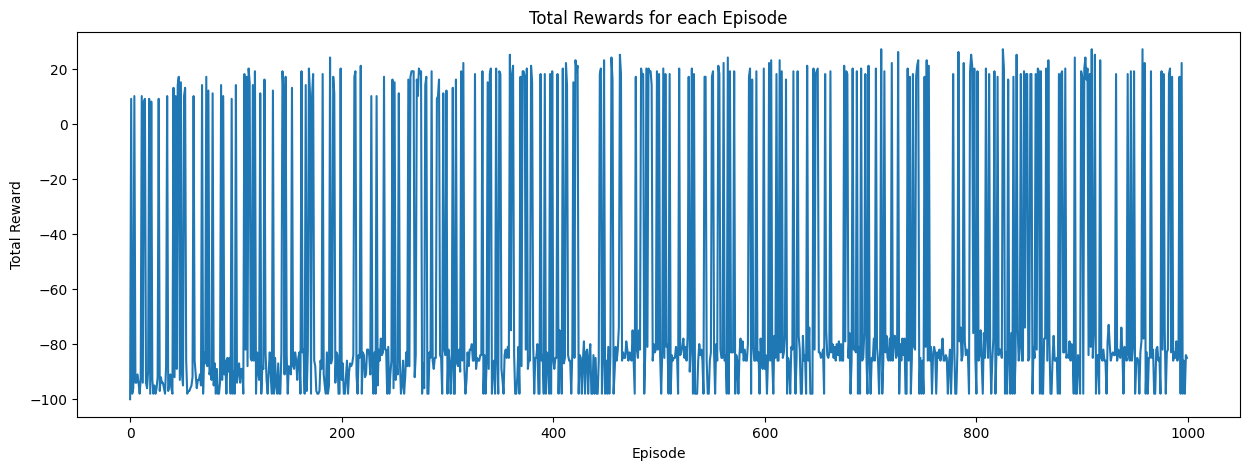

In [12]:
if __name__ == "__main__":
    main()

<img src="Pictures/AbelThirdIterationResult.png" width="1200" height="1200"> 

As seen in this graph, the learning process does not function well. There is a very high variability in the total rewards for the episodes and despite the program running for 1000 episodes there is no stability in sight. As my next steps to stabilise the Learning, I will modify Able so that he starts exploring at the beginning of his learning, but the more he understands the data the more conservative his guesses will be. This will be done by having a minimum Epsilon to avoid having 0 epsilon in addition to an epsilon Decay value which, in this case will make Able 1% less eager to experiment the more he learns.

Furthermore, I changed the amount of rewards I give to Able. In order to dissuade Able even further from hitting an already uncovered positionI decided to give for that action a very small negative reward. To avoid decimal numbers, I increased the rewards for successfully uncovering a number tile and hitting a mine by a factor of 100. I removed the reward for completing the grid because the completed grid will always have an advantage of at least 110 points. This is because the furthest a minesweeper grid can be solved without fully solving it is by having the last number tile not be pressed in favour of a mine. This would result in a penalization of -100 points and missing out on the last 10 points of the number tile. This advantage of 110 points of a fully solved minesweeper grid is sufficient, and no further weight needs to be given. 

In [13]:
class Able2:
    def __init__(self, actionSpace, obvsSpace, LearningRate=0.1, discountFactor=0.99, epsilon=0.1, epsilonDecay=0.99, minEpsilon=0.01):
        self.actionSpace = actionSpace
        self.obvsSpace = obvsSpace
        self.qTable = {}
        self.LearningRate = LearningRate
        self.discountFactor = discountFactor
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.minEpsilon = minEpsilon

    def getAction(self, state):
        stateKey = state.tobytes()
        if random.uniform(0, 1) < self.epsilon:
            action = tuple(self.actionSpace.sample())
        else:
            qValues = self.qTable.get(stateKey, np.random.rand(self.actionSpace.nvec.prod()) * 0.01)
            action = np.unravel_index(np.argmax(qValues), self.actionSpace.nvec)
        return tuple(action)

    def update(self, state, action, reward, nextState):
        stateKey = state.tobytes()
        nextStateKey = nextState.tobytes()
        actionID = np.ravel_multi_index(action, self.actionSpace.nvec)

        if stateKey not in self.qTable:
            self.qTable[stateKey] = np.zeros(self.actionSpace.nvec.prod())
        if nextStateKey not in self.qTable:
            self.qTable[nextStateKey] = np.zeros(self.actionSpace.nvec.prod())

        qValues = self.qTable[stateKey]
        nextQValues = self.qTable[nextStateKey]

        IdealNextAction = np.argmax(nextQValues)
        tempDiffTarget = reward + self.discountFactor * nextQValues[IdealNextAction]
        tempDiffError = tempDiffTarget - qValues[actionID]
        qValues[actionID] += self.LearningRate * tempDiffError

        #reducing the exploration with time
        if self.epsilon > self.minEpsilon:
            self.epsilon *= self.epsilonDecay


In [14]:
class MinesweeperEnv4(MinesweeperEnv3):
    def __init__(self, width=8, height=8, mines=10, seed=None):
        super(MinesweeperEnv4, self).__init__()
        self.minesweeper = Minesweeper(width, height, mines, seed)
        self.actionSpace = spaces.MultiDiscrete([width, height])
        self.obvsSpace = spaces.Box(low=-1, high=8, shape=(height, width), dtype=int)    

    def step(self, action):
        x, y = action
        reward = 0
        done = False

        result = self.minesweeper.revealTile(x, y)
        #if a mine is revealed, give a massive negative
        if result == -1:
            reward = -1000
            done = True
        #in order to avoid unecesary guesses, have a relatively tiny, negative reward
        elif result == 0:
            reward = -1
        else:
            reward = 10
            #An additional check if that was the last number tile. No reward was given
            if np.sum(self.minesweeper.covered & (self.minesweeper.grid != -1)) == 0:
                done = True
        state = self.getObvs()
        return state, reward, done, {}

In [15]:
def main():
    env = MinesweeperEnv4(width=8, height=8, mines=10, seed=69)
    ableAI = Able2(env.actionSpace, env.obvsSpace)
    print("Able woke up")

    episodes = 1000
    maxSteps = 100
    print("Able starts to train:")

    #creating an array in order to store the rewards
    rewards = []
    #creating variables in order to store the best version
    bestReward = -float('inf')
    bestState = None

    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0

            while not done and steps < maxSteps:
                action = ableAI.getAction(state)
                nextState, reward, done, conditions = env.step(action)
                ableAI.update(state, action, reward, nextState)
                state = nextState
                totalReward += reward
                steps += 1

            #at the end of the episode the total reward is stored
            rewards.append(totalReward)

            #if the current episode's total reward is better than or equal the previous best reward or the same, the best version is updated.
            #the "or equal" part is to have not only the best version, but also the latest
            if totalReward >= bestReward:
                bestReward = totalReward
                bestState = env

        #printing the best result
        print("Training complete. Best board state:")
        if bestState is not None:
            bestState.render()
        else:
            print("No best state saved.")

        #putting the rewards on a graph
        plt.figure(figsize=(15, 5))
        plt.plot(rewards)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

    except Exception as e:
        print(f"An error occurred during training: {e}")

Able woke up
Able starts to train:
Training complete. Best board state:
1 2 1 1 0 1 1 1 
* 2 * 2 1 2 * 1 
1 3 2 3 * 2 2 2 
1 2 * 2 1 1 1 * 
* 2 1 1 1 1 2 1 
1 2 1 1 1 * 1 0 
0 1 * 1 1 2 2 1 
0 1 1 1 0 1 * 1 


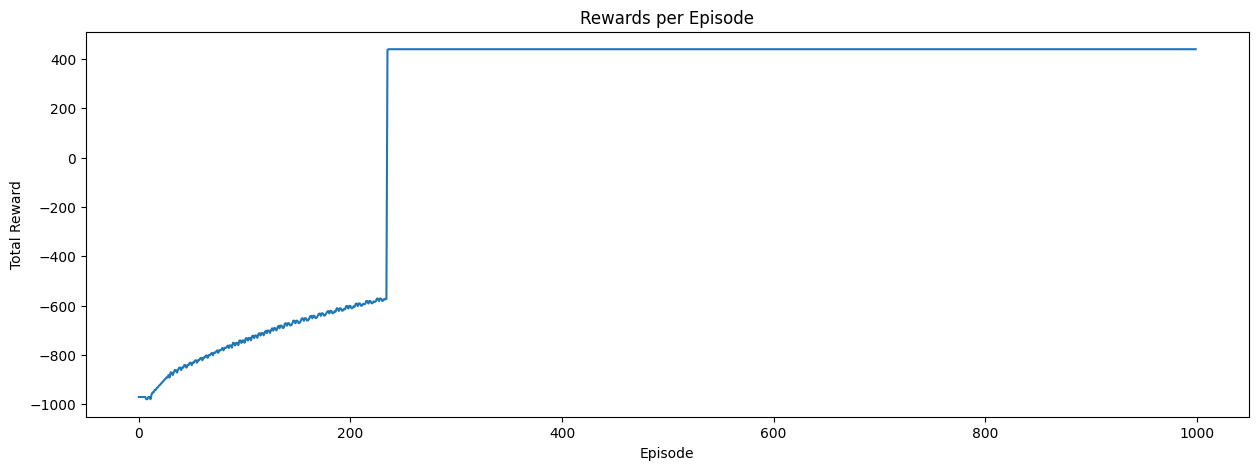

In [16]:
if __name__ == "__main__":
    main()

As seen here, Able successfully completed a minesweeper grid! Currently however, he has only tried a single one. This suggests overfitting instead of proper learning.  

#### Abel Training
My Strategy for the training for Abel will be to train Abel on a grid until he solves it successfully, after which the next grid with the next seed is initialised for Abel to train fully on it. I decided on this approach since it ensured that Abel will learn what the correct action will be, as the difference between different grids is too big as to allow Abel to efficiently learn if one mistake leads to an entirely different Minesweeper grid. The issue that arose however is the lack of variety in combination of computational limitations. For example, one of the Abel AIs I trained was on 16x16 grids with 20 mines. However, I only managed to train 750 different grids with a limit of 100,000 steps and generate a q-table file before that file became larger than 10 Gb, which is not fully feasable for easy use. I therefore also trained Abel on 16x16 grids with 20 mines with a limit of 10,000 steps, which allowed a maximum amount of 2000 different grids. I then decided to use smaller Minesweeper grids instead in order to reduce the file size, which should allow more diversity in grids and thereby a larger database of different states. However, this would put less value on the actions themselves, as Minesweeper grids can be solved faster, with luck playing a larger role. The two grid sizes I trained with this philosphy in mind was 4x4 grids with 4 mines, where I managed to easily train 100,000 different grids, and 8x8 grids with 10 mines, where I also managed to train 100,000 different grids. Both of these training attempts resulted in much smaller q-table sizes, both below 1 Gb. These different Trainings were used for the Final Evaluation, where I plan to further analyse the effectiveness of these training approaches.

For example: this is one of my training cells together with the modified Abel agent, which allows the use of pickle files to make use of Training saved on a qTable:

In [ ]:
class Abel2:
    def __init__(self, actionSpace, obvsSpace, LearningRate=0.1, discountFactor=0.99, epsilon=0.1, epsilonDecay=0.99, minEpsilon=0.01):
        self.actionSpace = actionSpace
        self.obvsSpace = obvsSpace
        self.qTable = {}
        self.LearningRate = LearningRate
        self.discountFactor = discountFactor
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.minEpsilon = minEpsilon

    def getAction(self, state):
        stateKey = state.tobytes()
        if random.uniform(0, 1) < self.epsilon:
            action = tuple(self.actionSpace.sample())
        else:
            qValues = self.qTable.get(stateKey, np.random.rand(self.actionSpace.nvec.prod()) * 0.01)
            action = np.unravel_index(np.argmax(qValues), self.actionSpace.nvec)
        return tuple(action)

    def update(self, state, action, reward, nextState):
        stateKey = state.tobytes()
        nextStateKey = nextState.tobytes()
        actionID = np.ravel_multi_index(action, self.actionSpace.nvec)

        if stateKey not in self.qTable:
            self.qTable[stateKey] = np.zeros(self.actionSpace.nvec.prod())
        if nextStateKey not in self.qTable:
            self.qTable[nextStateKey] = np.zeros(self.actionSpace.nvec.prod())

        qValues = self.qTable[stateKey]
        nextQValues = self.qTable[nextStateKey]

        IdealNextAction = np.argmax(nextQValues)
        tempDiffTarget = reward + self.discountFactor * nextQValues[IdealNextAction]
        tempDiffError = tempDiffTarget - qValues[actionID]
        qValues[actionID] += self.LearningRate * tempDiffError

        if self.epsilon > self.minEpsilon:
            self.epsilon *= self.epsilonDecay

    #methods for saving the training to a q Table
    def saveQTable(self, filePath):
        with open(filePath, 'wb') as f:
            pickle.dump(self.qTable, f)

    #method for loading a previous q Table training file
    def loadQTable(self, filePath):
        with open(filePath, 'rb') as f:
            self.qTable = pickle.load(f)

def trainAbel(seed, qTableFile, startSeed=0):
    env = MinesweeperEnv4(width=16, height=16, mines=40)
    abelAI = Abel2(env.actionSpace, env.obvsSpace)
    print("Able woke up :)")
    
    #if there a q Table is given, use it.
    if os.path.exists(qTableFile):
        try:
            abelAI.loadQTable(qTableFile)
            print("Successfully loading existing Q-table file")
        except (EOFError, pickle.UnpicklingError):
            print("An Error occurred while trying to load the Q-table file. Training will start with a new Q-table.")

    

    #here is a good example for showing how the computational limitations can cause problems, since I had to train this q Table in 100-grid-batches, which is not ideal to say the least.
    numOfGrids = 100
    episodesPerGrid = 100000
    maxStepsPerEpisode = 1000
    allRewards = []

    for grid in range(startSeed, numOfGrids):
        #for debugging and tracking progress:
        #print(f"Starting training on grid {grid + seed}...")
        gridRewards = []
        env = MinesweeperEnv4(width=16, height=16, mines=40, seed=(seed + grid))
        
        for episode in range(episodesPerGrid):
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0

            while not done and steps < maxStepsPerEpisode:
                action = abelAI.getAction(state)
                nextState, reward, done, _ = env.step(action)
                abelAI.update(state, action, reward, nextState)
                state = nextState
                totalReward += reward
                steps += 1

            gridRewards.append(totalReward)
            #check if
            if done and np.sum(env.minesweeper.covered & (env.minesweeper.grid != -1)) == 0:  # Successfully completed the grid
                break

        allRewards.append(gridRewards)
        #Additional print for debugging
        #print(f"Completed seed {grid + seed} in {len(grid_rewards)} episodes")

    #Saving the q Table after the whole training
    print("Saving the Q-table to a file")
    try:
        abelAI.saveQTable(qTableFile)
        print(f"Q-table was successfully saved to {qTableFile}")
    except Exception as e:
        print(f"There was an issue when saving the Q-table: {e}")

    print("Training is successfully completed")
    return allRewards

def main():
    qTableFile = "600.pkl"
    seed = 850
    abelProcess = multiprocessing.Process(target=trainAbel, args=(seed, qTableFile))
    abelProcess.start()
    abelProcess.join()
    print("Treining Process fully completed")

if __name__ == "__main__":
    main()

### Kane

Now it is time to implement Kane. His approach combines rule-based logic and MCTS (Monte Carlo Tree Search) in order to handle both deterministic and probabilistic aspects of the game. 

In the initial implementation, Kane's logic was based on simple rules to flag mines and uncover tiles. For example, if a number tile had exactly as many covered neighbours as its value, those neighbours were flagged as mines. However, during testing, it was observed that Kane often flagged unnecessary tiles and failed to uncover safe tiles correctly, indicating the need for further refinement in Kane’s logic.

In [ ]:
class Kane:
    def __init__(self, actionSpace, obvsSpace):
        self.actionSpace = actionSpace
        self.obvsSpace = obvsSpace

    def getAction(self, state):
        height, width = state.shape
        flagged = False
        uncovered = False

        for y in range(height):
            for x in range(width):
                if state[y, x] > 0:
                    covered_neighbors = [(i, j) for i in range(max(0, y-1), min(height, y+2))
                                         for j in range(max(0, x-1), min(width, x+2))
                                         if state[i, j] == -1]
                    if len(covered_neighbors) == state[y, x]:
                        for (i, j) in covered_neighbors:
                            if state[i, j] == -1:
                                state[i, j] = -2
                                flagged = True

        if not flagged:
            for y in range(height):
                for x in range(width):
                    if state[y, x] > 0:
                        flagged_neighbors = [(i, j) for i in range(max(0, y-1), min(height, y+2))
                                             for j in range(max(0, x-1), min(width, x+2))
                                             if state[i, j] == -2]
                        covered_neighbors = [(i, j) for i in range(max(0, y-1), min(height, y+2))
                                             for j in range(max(0, x-1), min(width, x+2))
                                             if state[i, j] == -1]
                        if len(flagged_neighbors) == state[y, x]:
                            for (i, j) in covered_neighbors:
                                state[i, j] = -3
                                uncovered = True

        if flagged or uncovered:
            for y in range(height):
                for x in range(width):
                    if state[y, x] == -2:
                        return (x, y, 1)
                    if state[y, x] == -3:
                        return (x, y, 0)

        return None

This was the result:  
Kane starts to play:  
Training complete. Best board state:  
\* 2 * * * * * *  
\* 2 * * * * * *  
\* * * * * * 2 2  
\* * * * * * * *  
\* * * * * * 2 1  
\* * * 1 * * 1 0  
\* * * * * * 2 1  
\* * * * * * * 1  
  
Here it can be seen, that Kane does not correctly identify simple deterministic flag positions, such as in the bottom right, where a number tile "1" only has a single covered tile surrounding it, yet no flagging action was taken.

In order to enhance Kane’s logic, prioritization was introduced to focus on processing lower number tiles first, increasing the likelihood of satisfying conditions quickly. Immediate uncovering was also ensured, so that tiles were uncovered immediately after flagging if the conditions were met. These improvements helped in reducing redundant operations and avoiding infinite loops.

Despite these improvements, Kane still struggled with uncertain situations where rule-based logic wasn't sufficient. To handle these scenarios, MCTS was introduced. The MCTS was designed to simulate different mine positions and check whether the mine placement caused conflicts with other number tiles. This simulation philosophy ensured that no number tile had more mines around it than its value indicated. The MCTS was applied as a fallback for difficult moves when deterministic logic did not provide a clear next move.

The implementation of MCTS involved developing methods for cloning the game state and marking tiles for simulations without altering the actual game state. This included the concept of "fake uncover" to mark tiles that would be uncovered in a simulation. The MCTS logic involved identifying unresolved tiles, which focused on number tiles with more uncovered tiles than potential mines. Branching was then created for each potential flag placement, simulating further flag placements and fake uncovers while assuming the initial flag placement was correct. Each simulation path was validated to ensure it was valid by checking if the number of flags matched the number on the tiles. Paths with excess flags or unmet conditions were marked as invalid. Out of all valid paths, one was randomly chosen as the next move.

Kane initially attempts to flag and uncover tiles using straightforward rules. If these rules do not yield a clear next move, MCTS is employed. If both rule-based logic and MCTS fail to determine a move, a fallback mechanism randomly selects a tile to uncover, ensuring Kane always makes a move.

In order to test and validate the performance and correctness of Kane’s actions, step-by-step rendering was implemented to observe each action taken by Kane. This facilitated the identification and correction of logical flaws. Several simulations were run on custom grids with predefined seeds to validate the performance and correctness of Kane’s actions. Detailed analysis of each step and debug prints were crucial in refining the logic and ensuring robust performance.

Kane’s logic flags all covered neighbours around a number tile if the number of covered neighbours equals the tile's value. It uncovers tiles around a number tile if the number of flagged neighbours matches the tile's value. When deterministic logic does not provide a clear move, Kane uses heuristics or random selection to decide the next action.

The Enhanced MCTS algorithm includes state representation and copying methods to create deep copies of the game state, ensuring independent simulations. It simulates different configurations of flag placements and fake uncovers. Enhanced methods validate simulated paths and identify safe tiles to uncover based on current flags and number tiles. State rendering provides visual feedback for debugging and understanding MCTS behavior. The best move is selected based on valid simulation paths, choosing a random valid path when multiple options are available.

During the Development howver, Kane initially faced issues with incorrect flag placement and early termination due to redundant operations and infinite loops. The logic was refined to avoid these problems, and the Enhanced MCTS was modified to handle recursion limits and ensure proper state updates, avoiding early termination and ensuring accurate simulations.

State management was another challenge. Methods were developed for cloning the game state to prevent unintended modifications during simulations. Logic was implemented to handle "fake" actions within simulations, ensuring accurate state transitions without altering the main game state. State representations were managed correctly as numpy arrays, preventing indexing errors and ensuring valid operations.

Debugging and visualization were crucial in refining the logic. Detailed debug prints were added to trace state changes and identify where the state might not be changing sufficiently. State rendering capabilities were integrated to visualize the simulation process, making it easier to identify and resolve issues. In order to provide consistent and predictable outputs, I created two new classes, CustomMinesweeperEnv and CustomMinesweeper. Their purpose is to allow a custom minesweeper grid to be predefined and used by the Minesweeper Environment instead of randomly generating the Minesweeper grid everytime, which makes testing very inconsistent.

The testing of the MCTS logic was done with this grid:

\* \* \* \* \* \* \* \*  
\* 3 1 2 1 2 2 \*  
\* 1 0 0 0 0 2 \*  
\* 2 0 0 0 0 1 \*  
\* 1 0 0 0 0 2 \*  
\* 2 0 0 0 0 1 \*  
\* 2 2 1 2 1 3 \*  
\* \* \* \* \* \* \* \* 

This grid is special as in it is entirely solveable with deterministic logic. While no tile can be solved deterministically on its own, adding additional tiles into the consideration there is only one correct solution. This is a perfect Test, since my basic rule-based aspect of Kane relies on a tile being solveable on its own, thereby forcing Kane to rely on MCTS in order to successfully solve this grid. Due to the MCTS only returning one action per step, The MCTS needs to be used 4 times. Inbetween these steps the basic, deterministic rule-based core of Kane takes over. This leads to these main steps:

Using MCTS for action selection  
Step 2: Action taken: (1, 0, 0)  
\* 2 * * * * * *  
\* 3 1 2 1 2 2 *  
\* 1 0 0 0 0 2 *  
\* 2 0 0 0 0 1 *  
\* 1 0 0 0 0 2 *  
\* 2 0 0 0 0 1 *  
\* 2 2 1 2 1 3 *  
\* * * * * * * *  

Using MCTS for action selection  
Step 8: Action taken: (7, 0, 0)  
\* 2 F 2 F 2 F 2  
\* 3 1 2 1 2 2 *  
\* 1 0 0 0 0 2 *  
\* 2 0 0 0 0 1 *  
\* 1 0 0 0 0 2 *  
\* 2 0 0 0 0 1 *  
\* 2 2 1 2 1 3 *  
\* * * * * * * *  

Using MCTS for action selection  
Step 15: Action taken: (0, 1, 0)  
\* 2 F 2 F 2 F 2  
2 3 1 2 1 2 2 F  
\* 1 0 0 0 0 2 2  
\* 2 0 0 0 0 1 F  
\* 1 0 0 0 0 2 2  
\* 2 0 0 0 0 1 F  
\* 2 2 1 2 1 3 2  
\* * * * * * * *  

Using MCTS for action selection  
Step 22: Action taken: (0, 7, 0)  
F 2 F 2 F 2 F 2  
2 3 1 2 1 2 2 F  
F 1 0 0 0 0 2 2  
2 2 0 0 0 0 1 F  
F 1 0 0 0 0 2 2  
2 2 0 0 0 0 1 F  
F 2 2 1 2 1 3 2  
2 * * * * * * *  

The only valid solution and Endresult of the MCTS decision is:  
F 2 F 2 F 2 F 2  
2 3 1 2 1 2 2 F  
F 1 0 0 0 0 2 2  
2 2 0 0 0 0 1 F  
F 1 0 0 0 0 2 2  
2 2 0 0 0 0 1 F  
F 2 2 1 2 1 3 2  
2 F 2 F 2 F 2 F  

In [2]:
# The final Result:
import random
import numpy as np
from itertools import combinations
import gym
from gym import spaces

#Env class for the custom Minesweeper class
class CustomMinesweeperEnv(MinesweeperEnv):
    def __init__(self, width=8, height=8, customGrid=None, seed=None):
        self.width = width
        self.height = height
        self.customGrid = customGrid
        self.seed = seed
        self.reset()

        self.actionSpace = spaces.MultiDiscrete([width, height, 2])
        self.obvSpace = spaces.Box(low=-1, high=8, shape=(height, width), dtype=int)

    def reset(self):
        if self.seed is not None:
            self.seed += 1
        self.minesweeper = CustomMinesweeper(self.width, self.height, self.customGrid, self.seed)
        return self.getObvs()

#Custom Minewsweeper class. Accepts grids as input
class CustomMinesweeper(Minesweeper):
    def __init__(self, width=8, height=8, customGrid=None, seed=None):
        self.width = width
        self.height = height
        self.seed = seed
        
        if customGrid is not None:
            self.grid = np.array(customGrid, dtype=int)
            self.noOfMines = np.sum(self.grid == -1)
        else:
            super().__init__(width, height, mines=10, seed=seed)
        
        self.covered = np.ones((height, width), dtype=bool)
        self.flags = np.zeros((height, width), dtype=bool)

        if customGrid is None:
            alreadyPlacedMines = 0
            while alreadyPlacedMines < self.noOfMines:
                x = random.randint(0, self.width - 1)
                y = random.randint(0, self.height - 1)
                if self.grid[y, x] == 0:
                    self.grid[y, x] = -1
                    alreadyPlacedMines += 1
                    for i in range(max(0, y-1), min(self.height, y+2)):
                        for j in range(max(0, x-1), min(self.width, x+2)):
                            if self.grid[i, j] != -1:
                                self.grid[i, j] += 1

#The Kane AI with its rulebased parts (MCTS is seperate)
class Kane:
    def __init__(self, actionSpace, obvSpace):
        self.actionSpace = actionSpace
        self.obvSpace = obvSpace

    #function for getting the position and state of the neighbours of a given tile
    def getNeighbours(self, state, y, x):
        height, width = state.shape
        neighbours = []
        for i in range(max(0, y-1), min(height, y+2)):
            for j in range(max(0, x-1), min(width, x+2)):
                if (i, j) != (y, x):
                    neighbours.append((i, j, state[i, j]))
        return neighbours

    #function for flagging tiles. A tile is flagged if it is fully deterministically clear.
    def flagTiles(self, state):
        height, width = state.shape
        actions = []

        while True:
            newActions = []
            for y in range(height):
                for x in range(width):
                    if state[y, x] > 0:
                        neighbours = self.getNeighbours(state, y, x)
                        flaggedCount = sum(1 for n in neighbours if n[2] == -2)
                        coveredNeighbours = [(i, j) for i, j, v in neighbours if v == -1]

                        if state[y, x] - flaggedCount == len(coveredNeighbours) and (state[y, x] - flaggedCount) != 0:
                            for i, j in coveredNeighbours:
                                #avoiding duplicate actions
                                if (j, i, 1) not in newActions:
                                    newActions.append((j, i, 1))

            if newActions:
                actions.extend(newActions)
                for action in newActions:
                    x, y, actionType = action
                    #assume the action is taken and update the state
                    state[y, x] = -2
                #reset newActions for the next loop
                newActions = []
                #restart the loop to process flagging first
                continue
            else:
                #exit loop if there are not new actions
                break

        return actions

    #function for uncovering tiles if the number of flags already satisfy the value of a tile
    def uncoverTiles(self, state):
        height, width = state.shape
        actions = []

        while True:
            newActions = []
            for y in range(height):
                for x in range(width):
                    if state[y, x] > 0:
                        neighbours = self.getNeighbours(state, y, x)
                        flaggedCount = sum(1 for n in neighbours if n[2] == -2)
                        coveredNeighbours = [(i, j) for i, j, v in neighbours if v == -1]

                        if state[y, x] - flaggedCount == 0:
                            for i, j in coveredNeighbours:
                                #avoiding duplicate actions
                                if (j, i, 0) not in newActions:
                                    newActions.append((j, i, 0))

            if newActions:
                actions.extend(newActions)
                for action in newActions:
                    x, y, actionType = action
                    #assume the action is taken and update the state
                    state[y, x] = 0
                #reset newActions for the next loop
                newActions = []
                #restart the loop to process uncovering
                continue
            else:
                #exit loop if there are not new actions
                break

        return actions

    def getAction(self, state):
        height, width = state.shape
        totalActions = []

        #flagging tiles
        flagging_actions = self.flagTiles(state)
        totalActions.extend(flagging_actions)

        #uncovering tiles
        uncovering_actions = self.uncoverTiles(state)
        totalActions.extend(uncovering_actions)

        if totalActions:
            return totalActions[0]

        #return None if no actions are found
        return None

    def update(self, state, action, reward, next_state):
        pass

#the MCTS class
class EnhancedMCTS:
    def __init__(self, env, simulations=1000, recursion_limit=100):
        self.env = env
        self.simulations = simulations
        self.recursion_limit = recursion_limit
        
    #function for getting the position and state of the neighbours of a given tile
    def getNeighbours(self, state, y, x):
        height, width = state.shape
        neighbours = []
        for i in range(max(0, y-1), min(height, y+2)):
            for j in range(max(0, x-1), min(width, x+2)):
                if (i, j) != (y, x):
                    neighbours.append((i, j, state[i, j]))
        return neighbours

    #function to find tiles that have uncertainty
    def identifyUnresolvedTiles(self, state):
        height, width = state.shape
        unresolvedTiles = []
        for y in range(height):
            for x in range(width):
                if state[y, x] > 0:
                    neighbours = self.getNeighbours(state, y, x)
                    flaggedCount = sum(1 for n in neighbours if n[2] == -2)
                    coveredNeighbours = [(i, j) for i, j, v in neighbours if v == -1]
                    if flaggedCount < state[y, x] and coveredNeighbours:
                        unresolvedTiles.append((y, x, state[y, x], flaggedCount, coveredNeighbours))
        return unresolvedTiles

    #function to simulating branching of the MCTS based on different potential decisions (flag placements) that occur
    def simulateBranch(self, state, unresolvedTiles, depth=0):
        if depth > self.recursion_limit or not unresolvedTiles:
            return []

        totalPaths = []
        y, x, value, flaggedCount, coveredNeighbours = unresolvedTiles[0]
        flagsNeeded = value - flaggedCount

        #for every combination place and uncover, and continue
        for comb in combinations(coveredNeighbours, flagsNeeded):
            newState = state.copy()
            for i, j in comb:
                newState[i, j] = -2
            for i, j in coveredNeighbours:
                if (i, j) not in comb:
                    newState[i, j] = -3
            
            if self.validatePath(newState):
                newSafeMoves = self.identifySafeMoves(newState)
                for sy, sx in newSafeMoves:
                    #fakeUncover, as MCTS is not allowed to actually uncover, but it needs to know if it would have uncovered
                    newState[sy, sx] = -3

                remainingTiles = self.identifyUnresolvedTiles(newState)
                furtherPaths = self.simulateBranch(newState, remainingTiles, depth + 1)
                totalPaths.append(newState)
                totalPaths.extend(furtherPaths)

        return totalPaths

    #if there are too many flags or if there are not enough flagged/covered tiles for a certain tile, this branch is not allowed.
    def validatePath(self, state):
        for y in range(state.shape[0]):
            for x in range(state.shape[1]):
                if state[y, x] > 0:
                    neighbours = self.getNeighbours(state, y, x)
                    flaggedCount = sum(1 for n in neighbours if n[2] == -2)
                    coveredNeighbours_count = sum(1 for n in neighbours if n[2] == -1)
                    if flaggedCount > state[y, x] or coveredNeighbours_count + flaggedCount < state[y, x]:
                        return False
        return True

    #function to fakeUncover
    def identifySafeMoves(self, state):
        safeMoves = []
        for y in range(state.shape[0]):
            for x in range(state.shape[1]):
                if state[y, x] > 0:
                    neighbours = self.getNeighbours(state, y, x)
                    flaggedCount = sum(1 for n in neighbours if n[2] == -2)
                    coveredNeighbours = [(i, j) for i, j, v in neighbours if v == -1]
                    if flaggedCount == state[y, x] and coveredNeighbours:
                        safeMoves.extend(coveredNeighbours)
        return safeMoves

    #function to render the current state with a message, for debug purposes
    def renderState(self, state, message=""):
        print(f"\n{message}")
        self.env.minesweeper.grid = state
        self.env.render()

    #function for returning the best move
    def getBestMove(self, state):
        unresolvedTiles = self.identifyUnresolvedTiles(state)
        totalPaths = self.simulateBranch(state, unresolvedTiles)
        
        validPaths = [path for path in totalPaths if self.validatePath(path)]
        if not validPaths:
            return None

        chosenPath = random.choice(validPaths)
        coveredTiles = [(y, x) for y in range(state.shape[0]) for x in range(state.shape[1]) if state[y, x] == -1]
        for y, x in coveredTiles:
            if chosenPath[y, x] == -3:
                #convert fakeUncover to actual uncover
                return (x, y, 0)

        return None

def main():
    customGrid2 = [
        [-1, 2, -1, 2, -1, 2, -1, 2],
        [2, 3, 1, 2, 1, 2, 2, -1],
        [-1, 1, 0, 0, 0, 0, 2, 2],
        [2, 2, 0, 0, 0, 0, 1, -1],
        [-1, 1, 0, 0, 0, 0, 2, 2],
        [2, 2, 0, 0, 0, 0, 1, -1],
        [-1, 2, 2, 1, 2, 1, 3, 2],
        [2, -1, 2, -1, 2, -1, 2, -1]
    ]

    seed = 1

    print(f"Trying custom grid with seed: {seed}")
    env = CustomMinesweeperEnv(width=8, height=8, customGrid=customGrid2)
    kane = Kane(env.actionSpace, env.obvSpace)
    mcts = EnhancedMCTS(env)

    episodes = 1
    stepLimit = 100

    rewards = []
    bestReward = -float('inf')
    bestState = None

    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            totalReward = 0
            steps = 0

            while not done and steps < stepLimit:
                if steps == 0:
                    #Ensuring the first action is always in the middle of the grid for the custom grid
                    action = (state.shape[0] // 2, state.shape[1] // 2, 0)
                    print("First action taken in the middle of the grid")
                else:
                    #first the core rule-based aspect of Kane is used
                    action = kane.getAction(state)
                    if action is None:
                        #if no action is found, apply MCTS
                        action = mcts.getBestMove(state)
                        if action is None:
                            #if there is still no action defined, use a random action as fallback
                            action = (random.randint(0, state.shape[1] - 1), random.randint(0, state.shape[0] - 1), 0)

                nextState, reward, done, _ = env.step(action)
                kane.update(state, action, reward, nextState)
                state = nextState
                totalReward += reward
                steps += 1

            rewards.append(totalReward)

            #saving the best state for final rendering
            if totalReward >= bestReward:
                bestReward = totalReward
                bestState = env

        #rendering the best final state after the loop with checks in case it is None
        if bestReward >= 0:
            if bestState is not None:
                bestState.render()

    #error catching for the entire loop
    except Exception as e:
        print(f"An error occurred during seed {seed}: {e}")

if __name__ == "__main__":
    main()

Trying custom grid with seed: 1
First action taken in the middle of the grid
F 2 F 2 F 2 F 2 
2 3 1 2 1 2 2 F 
F 1 0 0 0 0 2 2 
2 2 0 0 0 0 1 F 
F 1 0 0 0 0 2 2 
2 2 0 0 0 0 1 F 
F 2 2 1 2 1 3 2 
2 F 2 F 2 F 2 F 


In order to create a consistent and controlled environment for evaluating the AIs, I developed an additional function to generate custom Minesweeper grids. This function produces a specified number of grids with the following predefined characteristics:


Number of Grids: Defines how many grids we want. In our case, we want 20 custom grids in order to provide a robust dataset for evaluation.

Grid Size: Each grid is by default 8x8, which is a standard size for Minesweeper and provides a manageable yet challenging scenario for the AIs.

Mine Placement: Each grid containsby default 10 mines. The placement of mines is randomized, except for the middle tile.

Safe Middle Tile: The middle tile (at position [4,4] in a zero-indexed 8x8 grid) is guaranteed to be safe (i.e., not a mine). This ensured that for basic testing purposes, both AIs start with a known safe move, facilitating a consistent starting point for their algorithms. The custom grids were generated with a varying seed to ensure diversity in mine placement while maintaining the safe middle tile constraint.

### Testing and Evaluation

For the Evaluation I decided to analyse the performance of Kane and Abel according to the following rubrics:

1. Percentage of Grid uncovered
2. Win-rate

I focused on these rubrics, as I want to focus purely on the ability of the agents to solve Minesweeper. This forces me to disregard any computational limitation as a rubric, as theoretically, an agent that can solve any Minesweeper grid in 24 hours is more effective in solving Minesweeper than an agent that fails every grid but only requires 5 minutes to do so, despite the additional time required.

In order to add more dimensions to the evaluation, I trained 4 different Abel Q-Tables, as previously mentioned:  
1. "MultipleTriesBig750.pkl": This file holds the Q-Table for the training completed on 750 different 16 by 16 grids with 20 mines. With a limit of 100 thousand attempts at each grid until success, the Q-Table grew to a size of 10 Gb.
2. "MultipleTriesSmall2000.pkl": This file holds the Q-Table for the training completed on 2000 different 16 by 16 grids with 20 mines. With a limit of only 10 thousand attempts this time, the Q-Table grew to a size of 8.1 Gb.
3. "8x8With10.pkl": This file holds the Q-Table for the training completed on 10 thousand different 8 by 8 grids with 10 mines. With a limit of 10 thousand attempts, which was a lot more than necessary, the Q-Table only grew to a size of 467.3 Mb
4. And "4x4withExtended.pkl": This file holds the Q-Table for the training completed on 100 thousand different 4 by 4 grids with 4 mines. With a limit of 1.000 attempts, which was a lot more than necessary, the Q-Table only grew to a meager size of 6.6 Mb


The concept of the limitations of attempts for each grid is due to anomalous additional attempts necessary in order to successfully complete the grid. Around 60% of all 16-by-16 grids were completed in under 10 thousande grids. However, around 30% of all Grids required more than 10 thousand grids, while approximately 10% hit the limit of 100 thousand attmepts. I therefore reduced the limit for the secondary Q-Table training on the 16 by 16 grid to only 10 thousand attempts.

  
Furthermore, I will evaluate the Agents on 9 different grid types. These will consist of the 3 classic minesweeper grid sizes: 8 by 8, 16 by 16 and 16 by 30. In addition, each grid size will have 3 versions in order to provide additional depth to the evaluation, focusing on the mine density of the given grids. The categories in total will be:
1. 8 by 8: 2 mines, 10 mines and 20 mines
2. 16 by 16: 10 mines, 40 mines, 100 mines
3. 16 by 30: 20 mines, 99 mines, 150 mines


There will be 20 grids per grid category. In addition, I updated the main function in order to test both Kane and Able AIs on the same set of custom grids.
Due to the computational limitations of the file sizes, I trained the two Abel AIs with a file size larger than 8 Gb seperately, with only 5 grids per proccess.

For a more streamlined creation of the grids I created a new function "generateCustomGrids". It now offers the option to generate multiple grids with one call of the function. The parameters of the new function include a scenario variable, which accepts an array of scenarios. These scenarios should be in formatted like: (16, 16, 40). Furthermore, the additional parameter seedsList dictates how many grids will be generated with what seeds for each of the given scenarios.

The purpose of the following testing function is to allow for testing to be completed in parallel according to the seed list. This functions by setting the specific seeds to be tested in the seed list array, the Q-Table file that will be used for testing and finally the name of the csv file to which the results will be saved for later use. As seeds are used to control the testing grids, it was possible to split up the computational capacity of testing the large Q-Table files onto different computers in order to speed up the process to a more acceptable level.  

In [ ]:
#generating multiple custom grids
def generateCustomGrids(scenarios, seedsList):
    grids = []
    for parameters in scenarios:
        #extract the individual parts of the parameters
        width, height, mines = parameters
        for seed in seedsList:
            grid = np.zeros((height, width), dtype=int)
            alreadyPlacedMines = 0

            max_attempts = 1000
            attempts = 0

            random.seed(seed)  # Use the provided seed

            while alreadyPlacedMines < mines and attempts < max_attempts:
                x = random.randint(0, width - 1)
                y = random.randint(0, height - 1)
                if grid[y, x] == 0:
                    grid[y, x] = -1
                    alreadyPlacedMines += 1
                    for i in range(max(0, y-1), min(height, y+2)):
                        for j in range(max(0, x-1), min(width, x+2)):
                            if grid[i, j] != -1:
                                grid[i, j] += 1
                attempts += 1

            grids.append((grid, params))
    return grids

#this function enables more streamlined loading and initialisation of Abel
def initializeAndLoadAbel(filename, actionSpace, obvSpace):
    abelAI = Abel2(actionSpace, obvSpace)
    abelAI.loadQTable(filename)
    return abelAI

#Function to save the results of the testing to a csv file for later analysis
def savingResultsToCSV(filename, data):
    fileAlreadyExists = False
    try:
        with open(filename, 'r'):
            fileAlreadyExists = True
    except FileNotFoundError:
        pass

    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if not fileAlreadyExists:
            #a universal column structure, as Kane has a flagging percentage
            writer.writerow(['Scenario', 'Algorithm', 'Grid', 'Uncovered%', 'Win', 'Flagged%'])
        for row in data:
            writer.writerow(row)

#functions for calculating both overall uncovering and flagging
def coverageOfGrid(env):
    totalNoOfTiles = env.width * env.height
    uncoveredTiles = totalNoOfTiles - np.sum(env.minesweeper.covered)
    return (uncoveredTiles / total_tiles) * 100

def flaggingOfGrid(env):
    totalNoOfTiles = env.width * env.height
    flaggedTiles = np.sum(env.minesweeper.flags)
    return (flaggedTiles / totalNoOfTiles) * 100

def main():
    #for my seeds I chose to use the fibanocci sequence. Since I trained on the first 10 thousand seeds on various grids, I decided to start from 10 thousand minimum:
    #10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155
    #the seed list (a section of the seeds in order to reduce the computational strain)
    seedsList = [14930352, 24157817, 39088169, 63245986, 102334155]
    
    scenarios = [
        (8, 8, 10), (16, 16, 40), (16, 30, 99),
        (8, 8, 2), (16, 16, 10), (16, 30, 20),
        (8, 8, 20), (16, 16, 100), (16, 30, 150)
    ]

    customGrids = generateCustomGrids(scenarios, seedsList)    
    abel1Coverage = {params: [] for params in scenarios}
    abel1WinRates = {params: [] for params in scenarios}
    results = []

    qTableFile = "MultipleTriesBig750.pkl"  # Only one Abel model

    for customGrid, params in customGrids:
        width, height, mines = params
        env = MinesweeperEnv(width=width, height=height, mines=mines)

        # Abel 1
        abelAI1 = initializeAndLoadAbel(qTableFile, env.actionSpace, env.obvSpace)
        state = env.reset()
        done = False
        steps = 0
        stepLimit = 1000

        while not done and steps < stepLimit:
            action = abelAI1.getAction(state)
            x, y = action[0], action[1]
            if state[y, x] == -1:
                next_state, reward, done, _ = env.step(action)
                state = next_state
            steps += 1

        uncoveredPerc = calculate_coverage(env)
        abel1Coverage[params].append(uncoveredPerc)
        if np.sum(env.minesweeper.covered) == np.sum(env.minesweeper.grid == -1):
            abel1WinRates[params].append(1)
            results.append([params, 'Abel 1', len(abel1Coverage[params]), uncoveredPerc, 1, '-'])
        else:
            abel1WinRates[params].append(0)
            results.append([params, 'Abel 1', len(abel1Coverage[params]), uncoveredPerc, 0, '-'])

        del env, state, next_state, abelAI1
        gc.collect()
        #print for tracking progress:
        #print("Nächstes Feld")
    
    savingResultsToCSV("resultsAbelAIOnly2-5.csv", results)

    #visualizing the results after the testing for preliminary analysis.
    for params in scenarios:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(abel1Coverage[params], label='Abel AI 1 Uncovered %')
        plt.title(f'Uncovered Percentage for Grid Size {params[0]}x{params[1]} with {params[2]} Mines')
        plt.xlabel('Grid')
        plt.ylabel('Uncovered Grid (Percentage)')
        plt.legend()

        abel1WinRate = np.mean(abel1WinRates[params]) * 100
        plt.subplot(1, 2, 2)
        plt.bar(['Abel 1'], [abel1WinRate])
        plt.title(f'Win Rates for Grid Size {params[0]}x{params[1]} with {params[2]} Mines')
        plt.ylabel('Win Rate (Percentage)')

        plt.suptitle(f'Performance Metrics for Grid Size {params[0]}x{params[1]} with {params[2]} Mines')
        plt.show()

if __name__ == "__main__":
    main()

#### Evaluation
Let's focus first on the percentage of the grid uncovered, as it is a foundational metric in order to understand how well the different agents navigate the different minesweeper grids. Higher percentages of uncovered grid mean that that AI agent is more adept at exploring the board safely while avoiding the mines. However, uncovering more doesn’t always guarantee a win as you need to uncover enough for a win.

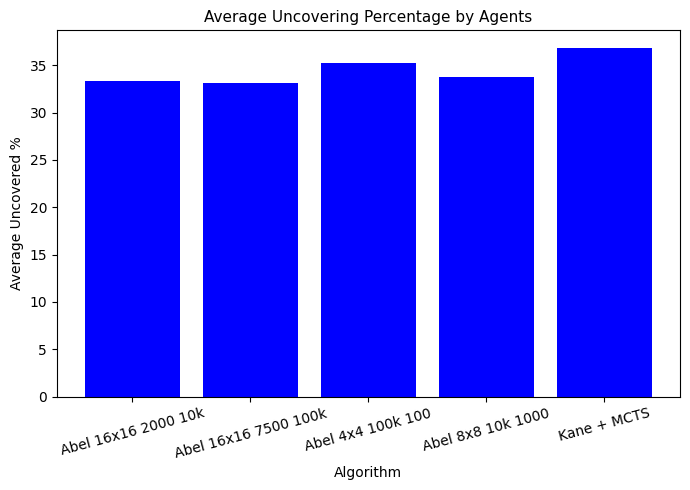

<Figure size 1000x600 with 0 Axes>

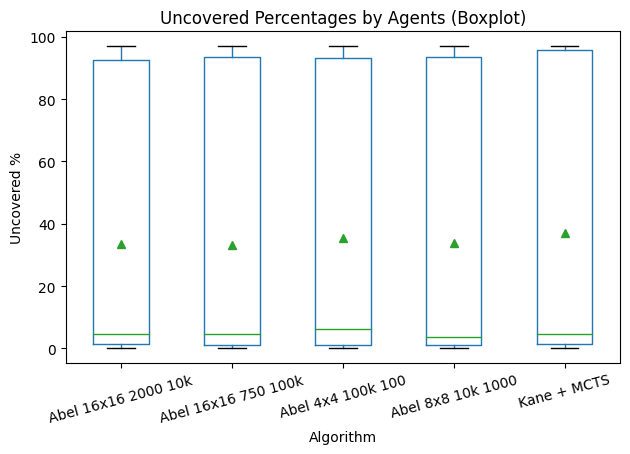

In [25]:
#This bar chart displays the average uncovering percentage of the different AI Agents
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(algorithm_avg['Algorithm'], algorithm_avg['Uncovered%'], color='blue')
ax.set_title('Average Uncovering Percentage by Agents', fontsize=11)
ax.set_ylabel('Average Uncovered %', fontsize=10)
ax.set_xlabel('Algorithm', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#This boxplot shows the distribution of uncovering percentage values for the different AI agents
plt.figure(figsize=(10, 6))
data.boxplot(column='Uncovered%', by='Algorithm', grid=False, showmeans=True)
plt.title('Uncovered Percentages by Agents (Boxplot)')
plt.suptitle('')
plt.ylabel('Uncovered %')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Uncovering Percentage
Kane + MCTS Performance in terms of uncovered percentage:  
The Average Uncovered%: 36.86%  
Standard Deviation: 44.36%  
The lowest and highest percentage: 0.21% and 96.88% respectively.  

The Abel Agents show slightly worse values:  
The Q-Table trained on 750 different 16x16 grids with a limit of 100 thousand attempts, which in the following analysis will be simply called "Abel 1", had an average of 33.34% with a maximum of 96.88% and a standard deviation of 42.34%.  
The Q-Table trained on 2000 different 16x16 grids with a limit of 10 thousand attempts, which in the following analysis will be simply called "Abel 2", in turn had a 33.18% average and a standard deviation of 41.58%  
The Q-Table trained on 10 thousand different 8x8 grids with a limit of 1 thousand attempts, which in the following analysis will be simply called "Abel 3": 33.79% average and a standard deviation of 42.60%  
And last but not least the Q-Table trained on 100 thousand different 4x4 grids with a limit of 100, which in the following analysis will be simply called "Abel 4" had a 35.26% average and a standard deviation of 42.19%  

Kane shows the strongest ability to uncover tiles safely, as indicated by the higher average but especially by the higher upper quartile compared to the other Algorithms. The high standard deviation (44.36%) indicates significant variability across different scenarios, even higher than the Abel agents. This suggests that in easier grids (those with lower mine density), Kane can more easily uncover large portions of the grid, while in more complex grids with higher mine densities, its performance decreases significantly. In the less mine-dense scenarios Kane achieves a higher uncovered percentage, showcasing its strength in more straight-forward deterministic situations, as the mine placements and thereby the number tile combinations are less complex. However, when faced with the more complex grids, Kane struggles, resulting in lower uncovered percentages. This is likely due to the increased randomness and difficulty in deducing safe cells with predetermined rules. As mines become densely packed, the available safe moves become more limited, reducing the agent's ability to maintain a high uncovered percentage.

It is important to note however that easy scenarios like (8, 8, 2), which have fewer mines, artificially inflates the maximum uncovered percentage. In such cases, the grid is relatively easy to navigate, allowing for higher uncovered percentages, which partially skews the overall evaluation when considering the maximum values.


  
The different Abel Q-Tables display similar performance in terms of uncovering grid cells. Notably, the Abel 4 Q-Table performs slightly better than the other version with an average of 35.26%. This suggests that Abel is more efficient on simpler, smaller grids, especially if trained on a larger variety of different grids. The smaller grid size of 4x4 with fewer mines (only 4) allows Abel to more effectively apply the learned patterns and Q-values, as Abel learns a high amount of smaller "snippets" of Minesweeper grid situations, resulting in a higher average uncovered percentage.

The larger 16x16 grids agents (Abel 1 and 2) show a slightly lower uncovered percentage, indicating that Abel's learning is less effective on bigger grids. While the Q-Tables have been trained on more data and larger grids, this doesn't necessarily translate into significantly better performance in terms of uncovering safe tiles, especially due to the limited variety of the grids in the learning set. Furthermore, the difference between the Abel 1 being trained with 100,000 attempts and Abel 2 with 10,000 attempts is minimal, suggesting that the additional attempts provide diminishing returns in terms of improving Abel's ability to uncover a higher percentage of the grid. This indicates that after a certain point, more attempts on the same grid does not necessarily lead to better decision making.


Overall, Kane's superior rule-based approach allows it to uncover large portions of the grid in simpler scenarios. However, this performance drops drastically as grid complexity increases. The Abel models on the other hand are consistent across different configurations, with some small differences in uncovered percentage depending on grid size and number of mines. Generally however they struggle to noticably increase the percentage of grid uncovered, even when trained on large datasets, with more attempts or with more variety. When trained on smaller grids (4x4 and 8x8), Abel performs slightly better, indicating that it learns slightly more in less complex environments. However, it is still not able to match Kane in simpler, larger grids.

<Figure size 1000x500 with 0 Axes>

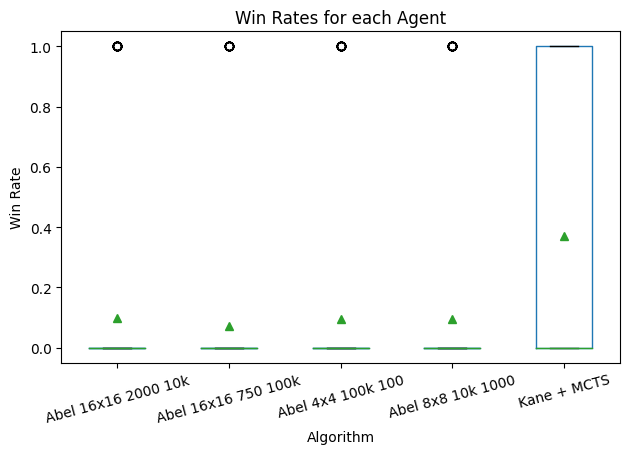

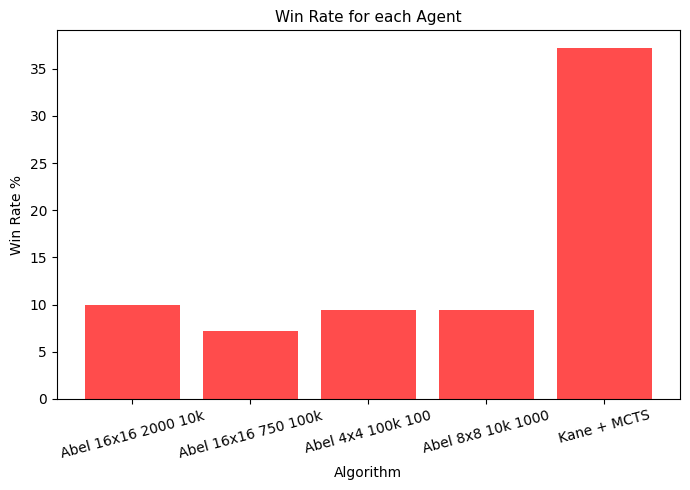

In [32]:
#Boxplot for Winrate distribution for the AI agents
plt.figure(figsize=(10, 5))
data.boxplot(column='Win', by='Algorithm', grid=False, showmeans=True)
plt.title('Win Rates for each Agent')
plt.suptitle('')
plt.ylabel('Win Rate')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#Barchart for Win rate
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(algorithm_avg['Algorithm'], algorithm_avg['Win'] * 100, color='red')
ax.set_title('Win Rate for each Agent', fontsize=11)
ax.set_ylabel('Win Rate %', fontsize=10)
ax.set_xlabel('Algorithm', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Win-Rate
While the percentage uncovered is more nuanced as an analytical metric, Win-rate is the ultimate measure of success in Minesweeper. A higher win-rate indicates that the agent not only uncovers some portions of the grid but also successfully identifies all mines and avoids critical mistakes, thereby successfully solving the minesweeper grid.

Kane Winrate Stats:  
Average Win Rate: 37.22%  
Standard Deviation: 48.47%  
The Winrate of Kane is the most impressive metric, with a high average of 37.22%. This is a strong indicator of its ability to successfully solve Minesweeper boards using its rule-based system. The large standard deviation on the other hand highlights that Kane can perform extremely well in certain scenarios while struggling in others. This is highlighted by the box plot, where the quartiles are spread out to the full range of possible win rates. This implies a large variety of performances between simpler scenarios such as (16, 16, 10), where Kane achieves a win rate of 16.67%, and the complex Scenarios like (16, 30, 150). This hints at the core issue of a rule-based agent such as Kane in situations where a lot of guess work is required, as the MCTS might simulate 8 different flag and uncover action combinations, all valid, while of course only one of them is correct. A Highly complex, cluttered grid with a high density creates more such situations, thereby created a greater inequality in win rates


Abel’s Win-Rate Performance:  
Abel 1: Win rate: 10%, Standard Deviation: 0.30  
Abel 2: Win rate: 7.22%, Standard Deviation: 0.26  
Abel 3: Win rate: 9.44%, Standard Deviation: 0.29  
Abel 4: Win rate: 9.44%, Standard Deviation: 0.29  

Abel consistently shows very low win-rates across all Q-Table configurations. The maximum win-rate recorded is 10%, for Abel 1. This becomes especially low if the amount of (8, 8, 2) grids are considered, as an 8 by 8 grid with only 2 mines is very easy to successfully solve. Despite Abel’s ability to uncover a significant portion of the grid as highlighted in the previous section, it struggles to achieve complete victory as often as Kane.
Comparing the different Abels with each other it can be seen that Abel 2 performs slightly worse than the other agents, potentially hinting at disadvantage from the relatively low attempt limit compared to the size and complexity of the training grids, as for Abel 2 the limit was hit the most out of all of the Q-Tables. The difference of win rate is however small enough as to be considered marginal. The very low standard deviation and the practically non-existant box in the box plot graphs for the Abel agents suggest that the this low win rate is very consistent in its performance, but this performance is very poor for most grids.


Overall, Kane’s deterministic approach gives it a significant edge over Abel in terms of win rate. The rule-based system ensures better average success, however, the very high standard deviation suggests that the difference between success rates between complex and simple grids is significant, while the Abels, despite their acceptable uncovering amount, struggle behind Kane with a significant gap, highlighting that Abel struggles to apply the learned strategies to win consistently. It should be noted however that Kane also struggles in the more difficult grids just as Abel does.


#### Scenario-Specific Performance

Now as an additional dimension to this analysis I will examine the performances of the agents in more detail across a few specific scenarios.

Scenario: (16, 16, 10)  
Kane:  
Uncovered Percentage: 85.6%  
Win Rate: 16.67%  
The different Abel Variants:  
Uncovered Percentage: 33-35%  
Win Rate: 7-10%  
Kane performs very well in this scenario, uncovering the majority of the grid and even securing a win 16.67% of the time. The low mine density of only 10 mines on a 16x16 grid makes it easier for Kane’s rule-based strategy to function effectively. Abel however performs significantly worse in this scenario, uncovering only a third of the grid on average and achieving a lower win rate. This indicates that Abel's learning-based strategy struggles to match Kane’s performance, even in relatively simple grids.


Scenario: (16, 30, 150)  
Kane:  
Uncovered Percentage: 1.05%  
Win Rate: 0%  
Abel Variants:  
Uncovered Percentage: 1-2%  
Win Rate: 0%  
This scenario is by far the most complex out of all grid sizes and mine densities. This is reflected by both Abel and Kane failing to not only never win, but also fail to uncover any significant amount of area. The dense mine distribution overwhelms Kane’s deterministic approach, preventing the agent from identifying safe moves with reasonable reliability. Abel also performs similarly poorly in this scenario despite its training as the training is not sufficient for the complexity of the grid.


Scenario: (16, 16, 100)  
Kane:  
Uncovered Percentage: 1.93%  
Win Rate: 0%  
Abel Variants:  
Uncovered Percentage: 1-2%  
Win Rate: 0%  
In this scenario with 100 mines on a 16x16 grid, Kane still performs poorly, uncovering less than 2% of the grid and failing to win any games, but shows slight improvement compared to the higher mine density version. Abel similarly fails in this scenario. Despite training on various grids, Abel's learned strategies are not sufficient to handle such high mine densities and relatively large grid sizes. The very low uncovered percentage and a zero win rate suggest that Abel is just as overwhelmed by this dense scenario as Kane.


Scenario: (16, 16, 40)  
Kane:  
Uncovered Percentage: 11.35%  
Win Rate: 6.67%  
Abel Variants:  
Uncovered Percentage: 33-35%  
Win Rate: 7-10%  
This moderately challenging scenario (40 mines on a 16x16 grid) is a classic grid and mine configuration and provides some insight into Kane’s middle-ground performance. While the uncovered percentage drops compared to simpler grids, Kane still manages to uncover about 11% of the grid and wins about 6.67% of games. This is a clear reduction from simpler scenarios, but Kane is still able to perform to a somewhat acceptable level. Interestingly to note is that the win rate seems to be relatively high compared to the average uncovered percentage, hinting that potentially Kane struggles during the initial stages of solving the grid, but after the beginning stages manages to solve the grid with high reliability. Interestingly, The Abel Variants show not only a higher uncovered percentage than Kane in this scenario, uncovering about 33-35% of the grid, but even a higher win rate, although only slightly higher. The higher uncovered percentage is similar to the (16, 16, 40) scenario, highlighting Abel's ability to solve 16 by 16 grids with reasonable accuracy. It still however struggles with the decision-making required to fully complete the grids.

#### Evaluation of Testing with Safe Move

In order to expand my evaluation I additionally modified the testing environment by having the "generateCustomGrids" function not only return the custom generated grids, but also return a list with one safe move for every grid generated. A safe move in Minesweeper is the concept that the first uncover action of the user is guaranteed to be a number 0 tile. Usually this process is approached by generating minesweeper grids until one has a "0" number tile at the location where the player tried to uncover a tile. This means however that my setup of comparing the different AI agents on the same grids would not work, as the AI agents would most likely choose different starting locations. I therefore preemptively created an action pair (with x and y coordinates) which were guaranteed to be a safe move. If the grid had too many mines as to not have number "0" tiles, I would instead allow number "1" tiles to be used for the safe move. This move would be used by all agents as their first step, thereby ensuring consistency while still implementing a safe move start.  
The testing data also included the initial uncovering resulting from the safe move and the final uncovering percentage, which will be used as a key metric in the following secondary evaluation in order to assess the agents performances in addition to, once again, win rate. 

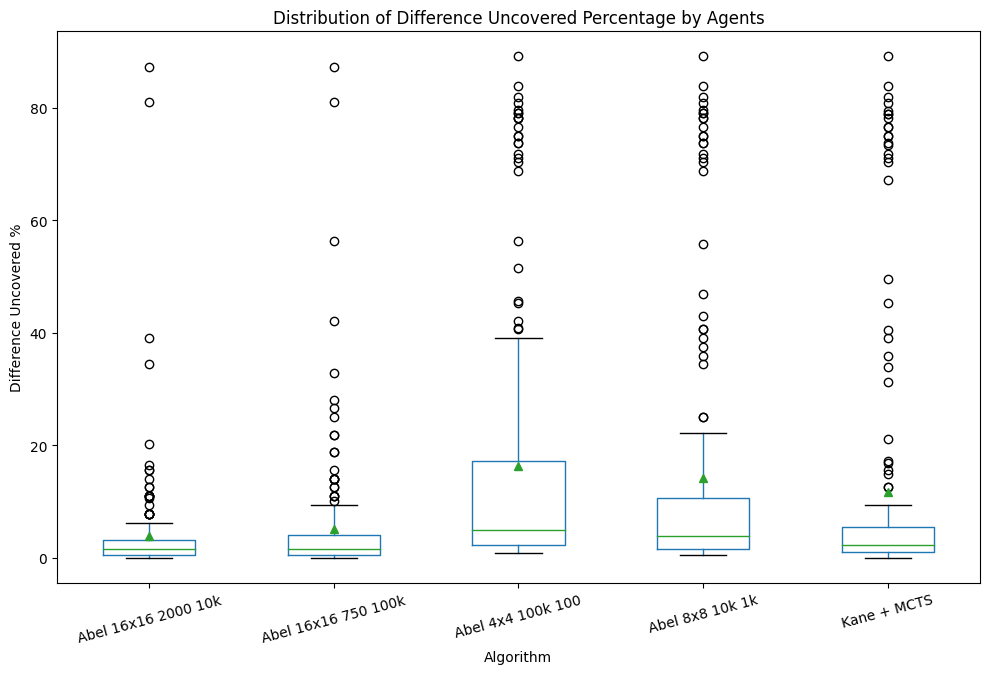

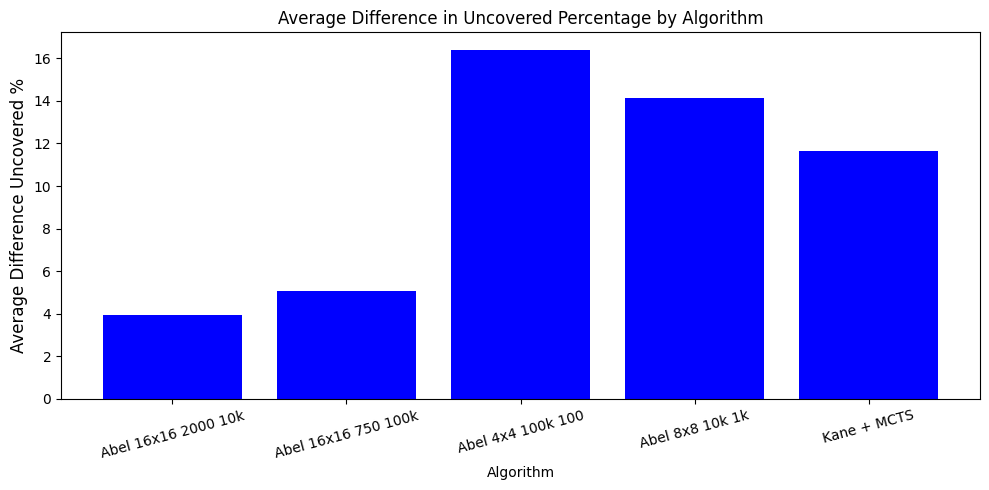

In [17]:
#boxplot for the percentage difference between the initial
fig, ax = plt.subplots(figsize=(10, 7))
data.boxplot(column='DifferenceUncovered%', by='Algorithm', grid=False, showmeans=True, ax=ax)
ax.set_title('Distribution of Difference Uncovered Percentage by Agents')
ax.set_ylabel('Difference Uncovered %')
plt.suptitle('')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#barchart displaying only the average
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(algorithmAvg['Algorithm'], algorithmAvg['DifferenceUncovered%'], color='blue')
ax.set_title('Average Difference in Uncovered Percentage by Algorithm', fontsize=12)
ax.set_ylabel('Average Difference Uncovered %', fontsize=12)
ax.set_xlabel('Algorithm', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Uncover Percentage

Kane:  
Mean Difference Uncovered Percentage: 11.66%  
Standard Deviation: 23.21%  
Kane on average manages to uncovering a noticable amount of additional tiles after the initial safe move. However, the very high standard deviation suggests that Kane’s performance varies across different scenarios, performing much better on simpler grids than on complex grids.  

Abel 4x4 100k 100 (Abel 4):  
Mean Difference Uncovered Percentage: 16.40%  
Standard Deviation: 23.69%   
Abel 4 seems to perfrom the best out of all other agents in terms of uncovering additional grid space after the initial move, with an average difference of 16.40%. This indicates that training on a high number of different, although very small, Minesweeper grids. Once again however, similarly to Kane, there is a large variability across different grids, highlighting the difficulty range between the different grid scenarios despite Abel's good ability to uncover tiles safely.  


Abel 8x8 10k 1k (Abel 3):  
Mean Difference Uncovered Percentage: 14.12%  
Standard Deviation: 23.13%  
Abel 3, similarly to the smaller Abel 4, also performs well at uncovering new areas after the initial safe move, with an average additional uncoverage of 14.12%. The variability remains similarly high to Abel 4, indicating that both Abel agents struggle with consistent performance across different scenarios. The slightly lower mean difference suggest an advantage in training on smaller grids even if these grid sizes are not part of the classic Minesweeper grid sizes. Interesting to note however is that both Abel 3 and 4 outperform Kane in this metric for the first time in this evaluation.  


Abel 16x16 2000 10k (Abel 2):  
Mean Difference Uncovered Percentage: 3.93%  
Standard Deviation: 9.92%  
Abel 16x16 750 100k (Abel 1):  
Mean Difference Uncovered Percentage: 5.05%  
Standard Deviation: 11.23%  
Both Abel 1 and 2 both perform very poorly in terms of safely uncovering additional tiles, with only ~4-5% uncovering on average. This indicates a severe lack of effectiveness from the training on a large minesweeper grid such as 16x16. While the lower standard deviation indicates that the agents are more consistent in their perfromance than the other agents, this does not add much of an advantage to the analysis of Abel 1 and 2 with such low uncovering percentages. Interesting to note however is that the more extensive training on each grid with 100 thousand attempts did provide a small advantage.

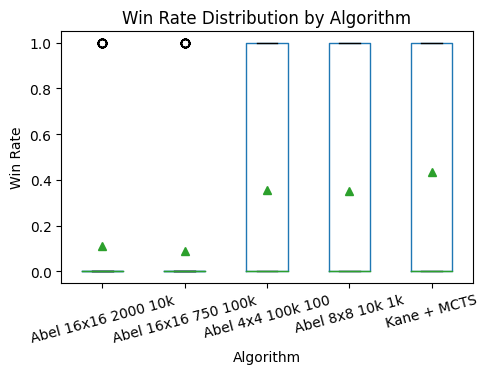

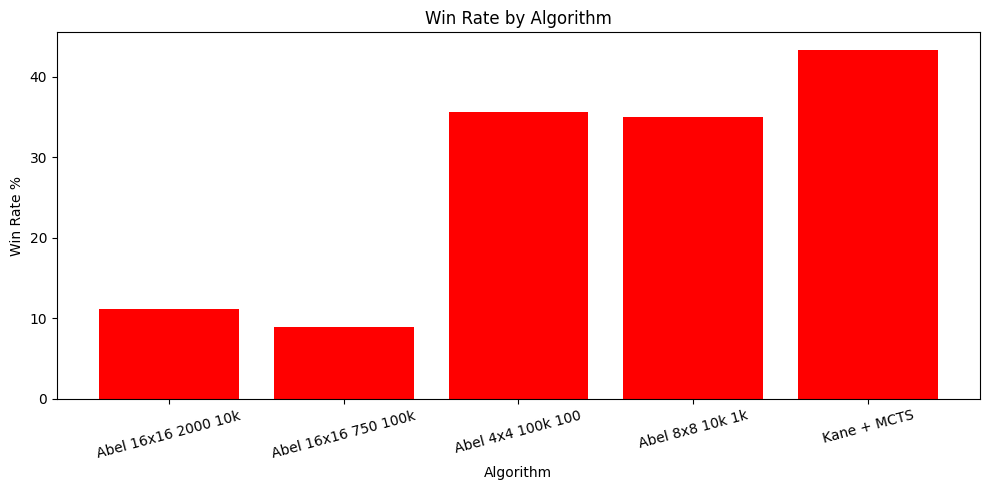

In [23]:
#Boxplot for Win Rate for the different agents
fig, ax = plt.subplots(figsize=(5, 4))
data.boxplot(column='Win', by='Algorithm', grid=False, showmeans=True, ax=ax)
ax.set_title('Win Rate Distribution by Algorithm')
ax.set_ylabel('Win Rate')
plt.suptitle('')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#barchart for Win rate for the different agents
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(algorithmAvg['Algorithm'], algorithmAvg['Win'] * 100, color='red')
ax.set_title('Win Rate by Algorithm', fontsize=12)
ax.set_ylabel('Win Rate %', fontsize=10)
ax.set_xlabel('Algorithm', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Win Rate Analysis
Kane:  
Average Win Rate: 43.33%  
Standard Deviation: 49.69%  
Analysis:  
Kane has a very strong average win rate, fully solving nearly half of the Minesweeper grids in the testing group, however Kane does have a significant amount of standard deviation, indicates that there is still inconsistency in the performance across grid configurations, most likely due to the varying complexities. The disparity in performances suggest that Kane's rule-based core excels in deterministic grids with lower mine densities, where there is a lower likelyhood for uncertain mine and number tile configurations.


Abel Variants:  
Abel 1: Win rate: 8.89%, Standard Deviation: 28.54%  
Abel 2: Win rate: 11.11%, Standard Deviation: 31.51%  
Abel 3: Win rate: 35.00%, Standard Deviation: 47.83%  
Abel 4: Win rate: 35.56%, Standard Deviation: 48.00%  
Analysis:  
Once again, all agents show a high standard deviation, however, only 2 Abel agents, Abel 1 and 2, perform poorly with a low average win rate of only 8.89% and 11.11% respectfully, with both furthermore having a standard deviation around 3 times larger than the mean, with 28.54% and 31.51%, indicating not only a clear struggle to successfully safely uncover a significant amount of tiles but also a lack of consistency. Despite the inconsistency still being prelavent for Abel 3 and 4, both these variants performed significantly better, with more than a third of all minesweeper grids successfully solved.


#### Scenario Specific Performance
In addition to these overall metrics for the safe-start evaluation, I want to look at specific scenarios again. The scenarios I chose was the three different mine densities for the 16 by 16 grids. Not only is this the classic medium grid size but it also offers Abel 1 and 2 a chance to show of their strengths.  

Scenario: (16, 16, 10)  
Kane:  
Uncovered Difference: 3.67%  
Win Rate: 100%  
Abel 1:  
Uncovered Difference: 0.74%  
Win Rate: 5%  
Abel 2:  
Uncovered Difference: 1.64%  
Win Rate: 10%  
Abel 3:  
Uncovered Difference: 3.71%  
Win Rate: 90%  
Abel 4:  
Uncovered Difference: 3.71%  
Win Rate: 90%  
Due to the limited mine density of this scenario, the initial uncover percentage was so high, that there was only a small percentage left to uncover additionally. Despite this, both Abel 1 and 2 had neither a significant win rate nor a high uncover difference, hinting more towards random guesses than the application of any learned strategies. On the other hand, Kane and both Abel 3 and 4 all have a very high win rate and additional uncover percentage. Kane especially has a win rate of 100%.

Scenario: (16, 16, 100)  
Kane:  
Uncovered Difference: 1.60%  
Win Rate: 0%  
Abel 1:  
Uncovered Difference: 1.74%  
Win Rate: 0%  
Abel 2:  
Uncovered Difference: 1.54%  
Win Rate: 0%  
Abel 3:  
Uncovered Difference: 3.42%  
Win Rate: 0%  
Abel 4:  
Uncovered Difference: 5.51%  
Win Rate: 0%  
In this challenging scenario with a mine amount of 100, neither Kane nor any of the Abel variants manage to win any games. The differences in uncovered tiles are also minimal, with Abel 4 managing to stand above the others with an average of 5.51% additional uncovering. However, despite its slight edge in uncovering more tiles over the other agents, it is still unable to safely uncover more than that, much less manage to successfully solve the entire grid.  

Scenario: (16, 16, 40)  
Kane:  
Uncovered Difference: 30.12%  
Win Rate: 30%  
Abel 1:  
Uncovered Difference: 3.18%  
Win Rate: 0%  
Abel 2:  
Uncovered Difference: 4.18%  
Win Rate: 0%  
Abel 3:  
Uncovered Difference: 35.12%  
Win Rate: 25%  
Abel 4:  
Uncovered Difference: 37.87%  
Win Rate: 25%  
This moderately difficult scenario displays a microcosm of the overall statistics. Abel 1 and 2 once again display a near complete lack of ability in solving the grid, while Kane, Abel 3 and 4 all have high win rates and additional uncover percentages. Interesting to note however is that for this scenario just like in the overall statistics, Kane has a lower uncover average than Abel 3 and 4, but has a higher win rate.

#### Overall Performance Evaluation


In the no-safe-start evaluation, the agents begin their game without any guaranteed safe move, forcing them to rely entirely on their decision-making abilities right from the start. This scenario highlights the raw problem-solving capabilities of the agents when faced with uncertainty right from the very first action. Kane, with its rule-based approach, performs well in simpler scenarios and manages to uncover a significant percentage of the grid and secures more wins than the Abel agents. However, with more complex grids, Kane seems to struggle with the unpredictability and randomness inherent in higher mine densities, which leads to less consistent results and a higher standard deviation. The Abel agents show a mixed performance. Abel 1 and Abel 2, which use the Q-Tables trained on 16 by 16 grids, struggle to consistently improve their uncovered percentages or win rates, even when trained with larger datasets or more attempts per grid. Their learning appears to plateau, with diminishing returns despite the additional training efforts. In contrast however, Abel 3 and Abel 4, which were trained on smaller 8 by 8 grids and 4 by 4 grids respectively, demonstrate slightly better performance in terms of uncovered percentages, especially in simpler scenarios. These smaller training grids offer a less complex learning environment, allowing these agents to learn and apply their learned strategies more effectively. However, despite these improvements, all Abel agents still fall short of Kane's overall performance, especially in win rates.

In contrast, the safe start evaluation, as mentioned before, provides the agents with an initial move that is guaranteed to be safe, which significantly alters the dynamic. This initial safe move helps reduce the randomness at the start of the grids and provides the agents with a foundation of safe uncovered tiles, allowing them to proceed with a clearer initial understanding of the board. In this setting, Kane and the Abel agents show improved performance. By guaranteeing an initial safe move, the agents can partially bypass the initial randomness associated with the first move, which otherwise introduces unnecessary risk. Kane benefits most from this condition, leveraging the safe start to further increase its uncovered percentage and win rate, especially in the simpler scenarios. The Abel agents, particularly Abel 3 and Abel 4, also benefit from the safe start, showing improvement both in terms of uncover percentages and win rates. These agents even perform better than Kane in terms of additional uncover percentage in some scenarios, especially on smaller grids. However, despite this improvement, their win rates are still lower than those of Kane, suggesting that while the safe start helps them uncover more tiles, they still struggle with fully solving the grids in more complex scenarios. Abel 1 and Abel 2 however, which were trained on the 16 by 16 grids, show only marginal improvements, indicating that even with a safe start, their training does not sufficiently prepare them to handle larger or more complex grids effectively.  


Overall, Kane's rule-based method proves superior in terms of achieving higher win rates and navigating Minesweeper grids safely, particularly in scenarios where deterministic situations occur more often. The Abel agents, despite extensive training on different grids, struggle to achieve the same level of success. Their performance improves with smaller grids and simpler scenarios but remains limited when applied to larger, more complex grids. The safe start significantly enhances the performance of both types of agents, with the biggest improvement observed for the Abel variants trained on the smaller grids, highlighting that this is the best approach to training a Reinforcement Learning agent with Q-learning. The gap between Kane and the Abel variants however still remains, especially in terms of the ultimate measure of success: winning the game. 